In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import math
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

2024-05-31 17:40:37.020612: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-31 17:40:37.940419: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [17]:
def corrupt(x, noise_factor=0.3):
    """ apply random noise to the input images. """
    noise = tf.random.normal(shape=tf.shape(x), mean=0.0, stddev=noise_factor, dtype=tf.float32)
    x_noisy = x + noise
    x_noisy = tf.clip_by_value(x_noisy, 0.0, 1.0)
    return x_noisy

In [18]:
class DenoisingAutoencoder(tf.keras.Model):
    def __init__(self, dimensions=[784, 512, 256, 64]):
        super(DenoisingAutoencoder, self).__init__()
        self.encoder_layers = []
        self.decoder_layers = []
        
        # build the encoder
        for i in range(len(dimensions)-1):
            self.encoder_layers.append(
                tf.keras.layers.Dense(dimensions[i-1], activation='tanh',
                                     kernel_initializer=tf.keras.initializers.RandomUniform(
                                         minval=-1.0/math.sqrt(dimensions[i]),
                                         maxval=1.0/math.sqrt(dimensions[i])
                                     ))
            )
            
        # build the decoder
        for i in range(len(dimensions)-1, 0, -1):
            self.decoder_layers.append(
                tf.keras.layers.Dense(dimensions[i-1], activation='tanh',
                                     kernel_initializer=tf.keras.initializers.RandomUniform(
                                         minval=-1.0/math.sqrt(dimensions[i]),
                                         maxval=1.0/math.sqrt(dimensions[i])
                                     ))
            )
            
    def call(self, x, training=False):
        if training:
            x = corrupt(x)
                
        for layer in self.encoder_layers:
            x = layer(x)
                
        z = x # latent representation
            
        for layer in self.decoder_layers:
            x = layer(x)
            
        return x

In [19]:
def preprocess(x):
    x = x.astype('float32') / 255.0
    x = x.reshape((x.shape[0], -1))
    return x

In [22]:
def test_mnist():
    (x_train, _),(x_test, _) = mnist.load_data()
    x_train, x_test = preprocess(x_train), preprocess(x_test)
    mean_img = np.mean(x_train, axis=0)
    x_train -= mean_img
    x_test -= mean_img
    
    # build and compile model
    autoencoder = DenoisingAutoencoder(dimensions=[784, 256, 64])
    autoencoder.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001), loss='mse')
    
    # train
    autoencoder.fit(x_train, x_train,  epochs=10, batch_size=50, validation_data=(x_test, x_test))
    
    # test the autoencoder
    n_example = 15
    test_xs = x_test[:n_example]
    recon = autoencoder(test_xs, training=False)
    
    # plot example reconstruction
    fig, axs = plt.subplots(2, n_example, figsize=(10, 2))
    for example_i in range(n_example):
        axs[0][example_i].imshow(np.reshape(test_xs[example_i,:]+ mean_img, (28,28)), cmap='gray')
        axs[1][example_i].imshow(np.reshape(recon[example_i,:]+ mean_img, (28,28)), cmap='gray')
    plt.show()

Epoch 1/10
1200/1200 [==============================] - 6s 5ms/step - loss: 0.0196 - val_loss: 0.0246
Epoch 2/10
1200/1200 [==============================] - 6s 5ms/step - loss: 0.0159 - val_loss: 0.0291
Epoch 3/10
1200/1200 [==============================] - 6s 5ms/step - loss: 0.0157 - val_loss: 0.0296
Epoch 4/10
1200/1200 [==============================] - 6s 5ms/step - loss: 0.0155 - val_loss: 0.0292
Epoch 5/10
1200/1200 [==============================] - 6s 5ms/step - loss: 0.0153 - val_loss: 0.0292
Epoch 6/10
1200/1200 [==============================] - 6s 5ms/step - loss: 0.0151 - val_loss: 0.0283
Epoch 7/10
1200/1200 [==============================] - 6s 5ms/step - loss: 0.0149 - val_loss: 0.0270
Epoch 8/10
1200/1200 [==============================] - 6s 5ms/step - loss: 0.0147 - val_loss: 0.0274
Epoch 9/10
1200/1200 [==============================] - 6s 5ms/step - loss: 0.0145 - val_loss: 0.0266
Epoch 10/10
1200/1200 [==============================] - 6s 5ms/step - loss: 0.014

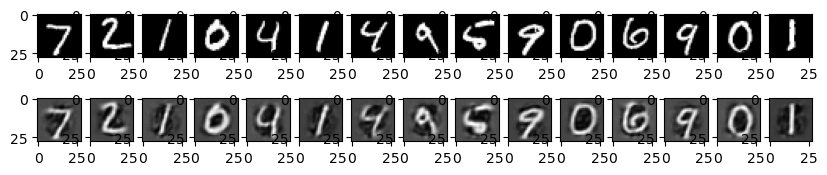

In [23]:
if __name__ == "__main__":
    test_mnist()